This is my capstone project for the Udacity Machine Learning Nanodegree.

Import the libraries needed.

In [1]:
import pandas as pd
import numpy as np
import keras as kr
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from os import listdir

Using TensorFlow backend.


Get the data.

Since we already know the name of the specific stock we are trying to get from the name of the file, we can drop that column in the dataframe.

In [2]:
directory = 'sandp500/individual_stocks_5yr'
dir_listing = listdir(directory)

In [3]:
symbols_list = []

for symbol in dir_listing:
    symb = symbol.split('_')[0]
    symbols_list.append(symb)
    
csv_file = '{}/{}_data.csv'.format(directory, symbols_list[0])
dataset = pd.read_csv(csv_file)

In [4]:
def getting_preprocessed_data(symbol):
        csv_file = '{}/{}_data.csv'.format(directory, symbol)
        df = pd.read_csv(csv_file)
        df = df.assign(trading_date = pd.to_datetime(df['Date']))
        df = df.drop('Name', 1)
        df = df.drop('Date', 1)
        df.set_index(['trading_date'], inplace=True)
        df = np.log(df)
        #below was found at https://stackoverflow.com/questions/29314033/python-pandas-dataframe-remove-empty-cells
        df.replace('', np.nan, inplace=True)
        df.dropna(subset=['Open'], inplace=True)
        return df

In [5]:
def plotting_stocks(symbols_list, amount_of_stocks=0):
    if amount_of_stocks == 0:
        amount_of_stocks = len(symbols_list)
        
    for symbol in symbols_list[:amount_of_stocks]:
        fig, ax = plt.subplots()
        fig.subplots_adjust(right=0.7)
        df = getting_preprocessed_data(symbol)
        print(symbol)
        df.Open.plot(ax=ax, style='b-', figsize=(20,10))
        # same ax as above since it's automatically added on the right
        df.Volume.plot(ax=ax, style='r-', secondary_y=True, figsize=(20,10))
        plt.show()
        
        #below is the Daily Returns calculation to put into the Sharpe Ratio. 
        df_preprocessed = df.assign(Daily_Returns = np.divide((df.Open - df.Close), df.Close) * 100)

        #Below is the calculation for the Sharpe Ratio column. 
        df_preprocessed = df_preprocessed.assign(Sharpe_Ratio = np.divide((df_preprocessed.Daily_Returns - 0.046), np.std(np.array([df_preprocessed.Open, df_preprocessed.High, df_preprocessed.Low, df_preprocessed.Close]))))

        #Below is the rate of change (momentum) for the specific stock. 
        df_preprocessed = df_preprocessed.assign(Rate_of_Change = (np.divide(df_preprocessed.Close, df_preprocessed.Open) - 1) * 100)

        df_preprocessed.plot.scatter(x='Volume', y='Open', label="AAL", figsize=(20,10))
        plt.show()
        df_preprocessed.plot.scatter(x='Open', y='Sharpe_Ratio', label="Sharpe Ratio Open", figsize=(20,10))
        plt.show()
        df_preprocessed.plot.scatter(x='Volume',y='Sharpe_Ratio', label="Sharpe Ratio Volume", figsize=(20,10), use_index=True)
        plt.show()
        df_preprocessed.plot.scatter(x='Volume',y='Close', label="Volume Close", figsize=(20,10), use_index=True)
        plt.show()
        return df_preprocessed

AAL


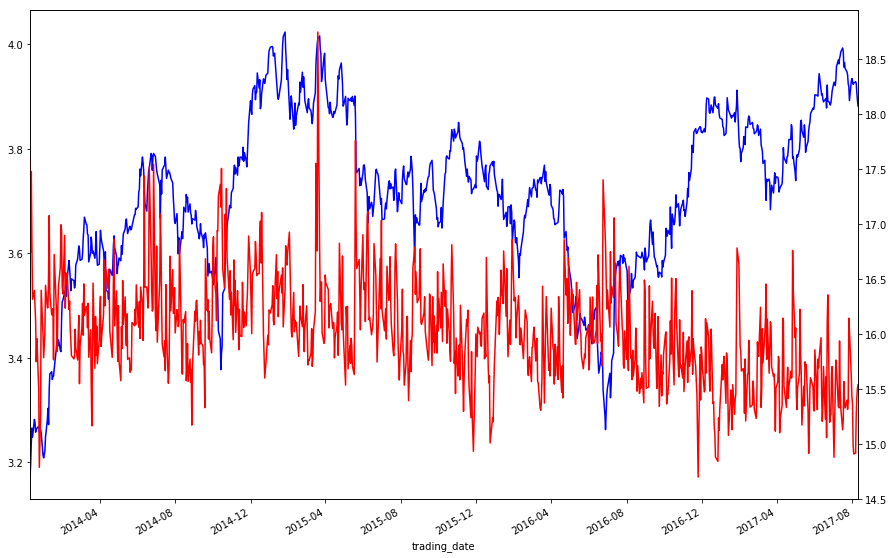

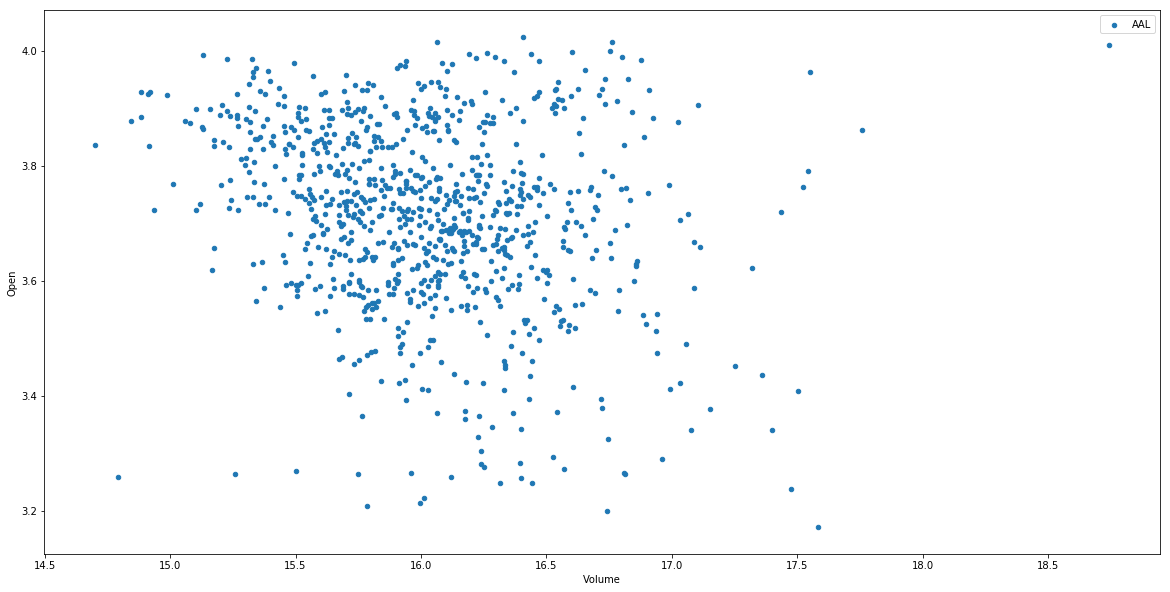

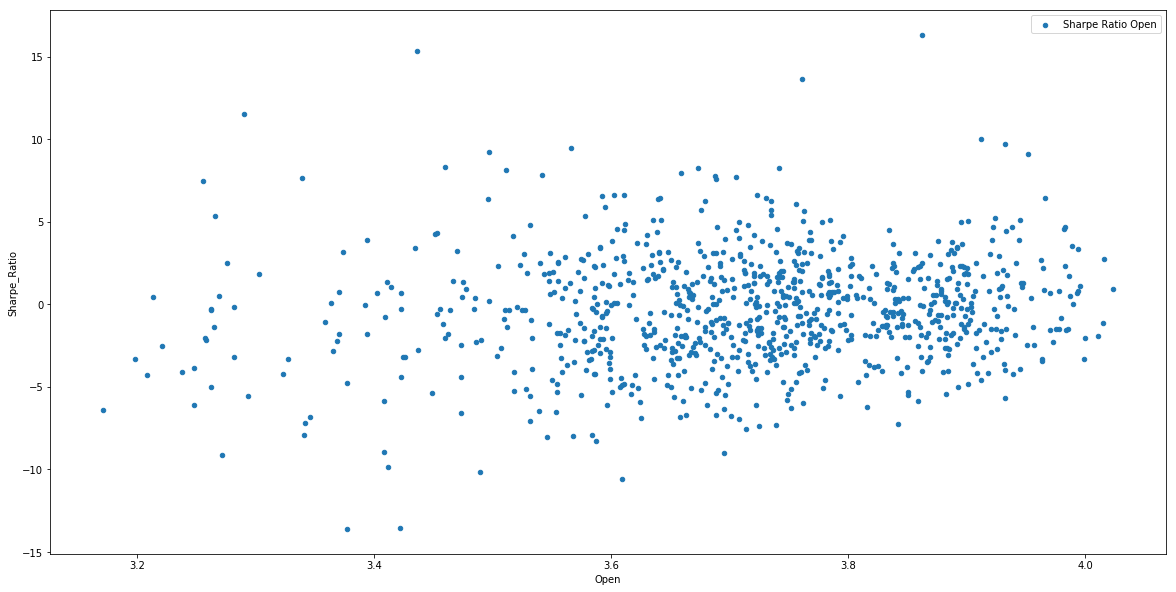

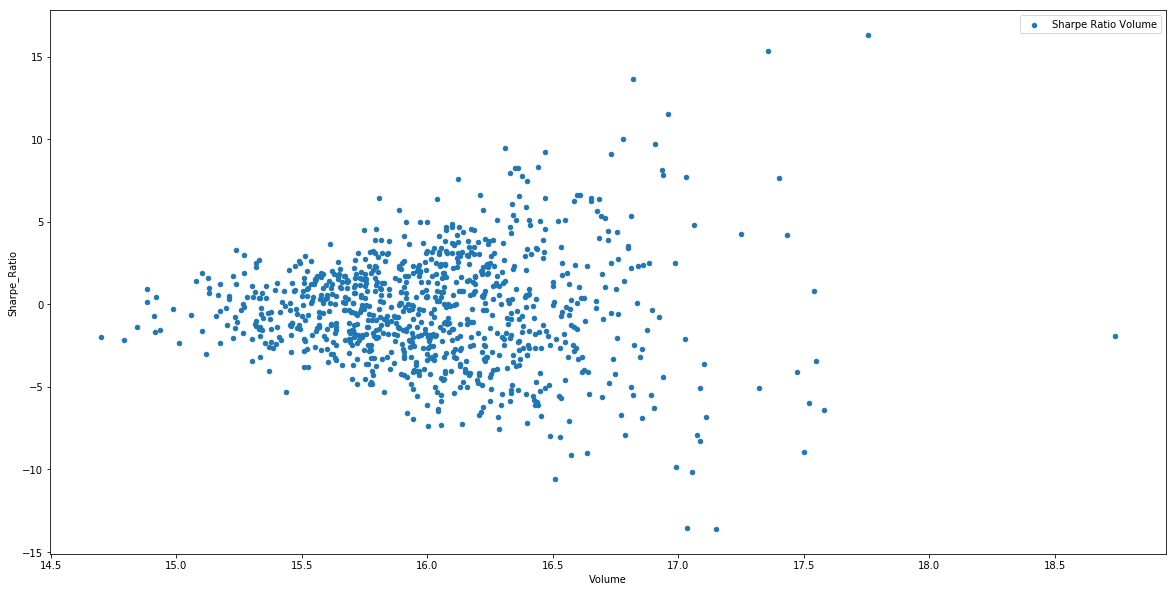

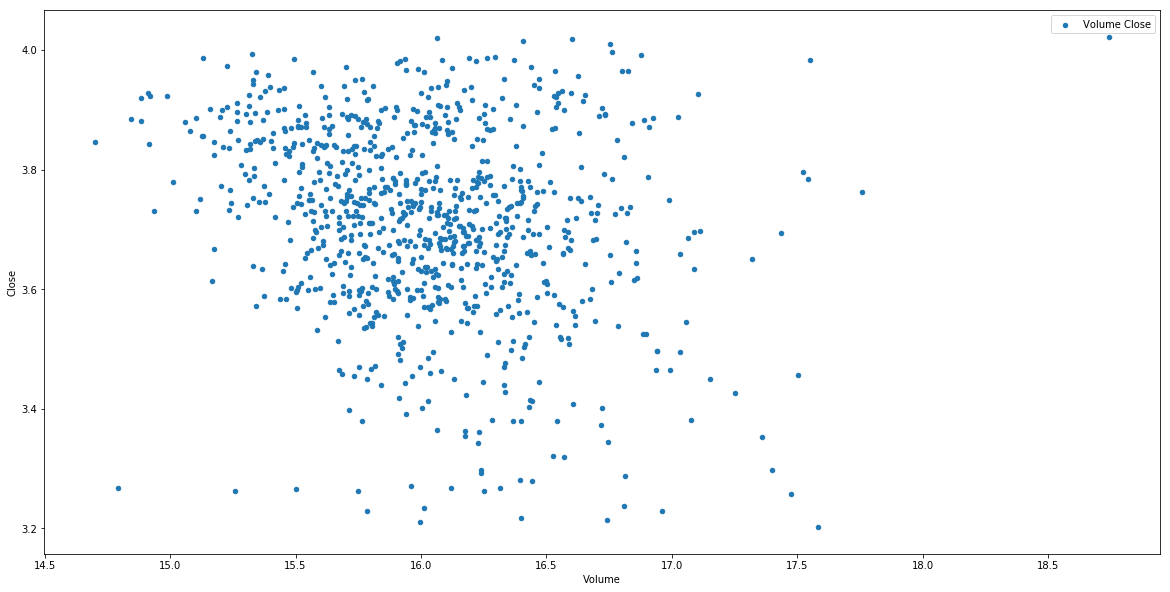

In [6]:
# printing out the first four stocks to get an idea of how each stock is individually represented.
raw_features = plotting_stocks(symbols_list, 1)

In [7]:
raw_closing = raw_features['Close']
raw_features = raw_features.drop('Close', axis = 1)
display(raw_features.head(n=1))

,Open,High,Low,Volume,Daily_Returns,Sharpe_Ratio,Rate_of_Change
trading_date,,,,,,,
2013-12-09,3.171784,3.236323,3.15487,17.581288,-0.96674,-6.369843,0.976177


In [8]:
# from the Finding Donors project
scaler = MinMaxScaler()
numerical = ['Open', 'High', 'Low', 'Volume']
raw_features[numerical] = scaler.fit_transform(dataset[numerical])

display(raw_features.head(n=1))

,Open,High,Low,Volume,Daily_Returns,Sharpe_Ratio,Rate_of_Change
trading_date,,,,,,,
2013-12-09,0.0,0.008701,0.0,0.301245,-0.96674,-6.369843,0.976177


In [9]:
raw_closing = raw_closing.reshape(-1,1)
raw_closing = scaler.fit_transform(raw_closing)

/home/kevin/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


In [10]:
from sklearn.cross_validation import train_test_split

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(raw_features, raw_closing, test_size=0.20, random_state=0)

print("Training set has {} samples".format(X_train.shape[0]))
print("Testing set has {} samples".format(X_test.shape[0]))

Training set has 740 samples
Testing set has 186 samples


In [12]:
# From my Finding Donors project. 

from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [13]:
learner = SVR()

In [14]:
train = learner.fit(X_train, y_train.ravel())

In [15]:
pred = learner.predict(X_test)
accuracy = mean_squared_error(y_test, pred)

print(accuracy)

0.00609825958261


# This is the RNN-LSTM Section

This section is the main analysis.  The above Support Vector Maching section is to compare against and see what type of correlation and accuracy I can achieve. 

In [40]:
X_train_array = np.array(X_train)
X_test_array = np.array(X_test)

(740, 7)

In [48]:
from keras.models import Sequential

from keras.layers import Dense, Activation, LSTM

In [54]:
model = Sequential()
model.add(Dense(7, input_shape=(740, 7)))
model.add(LSTM(7, dropout=0.2, return_sequences=True))
model.add(LSTM((7)))

In [55]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=['accuracy'])

In [57]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 740, 7)            56        
_________________________________________________________________
lstm_5 (LSTM)                (None, 740, 7)            420       
_________________________________________________________________
lstm_6 (LSTM)                (None, 7)                 420       
Total params: 896
Trainable params: 896
Non-trainable params: 0
_________________________________________________________________
